<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Tay-tay-Text-Theatre" data-toc-modified-id="Tay-tay-Text-Theatre-1">Tay-tay Text Theatre</a></span><ul class="toc-item"><li><span><a href="#Measuring-repetitiveness?" data-toc-modified-id="Measuring-repetitiveness?-1.1">Measuring repetitiveness?</a></span></li><li><span><a href="#Repetitiveness-≈-compressibility?" data-toc-modified-id="Repetitiveness-≈-compressibility?-1.2">Repetitiveness ≈ compressibility?</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.3">Imports</a></span></li></ul></li><li><span><a href="#DS-Process" data-toc-modified-id="DS-Process-2">DS Process</a></span><ul class="toc-item"><li><span><a href="#Gather-Data" data-toc-modified-id="Gather-Data-2.1">Gather Data</a></span></li><li><span><a href="#Assess" data-toc-modified-id="Assess-2.2">Assess</a></span></li><li><span><a href="#Clean" data-toc-modified-id="Clean-2.3">Clean</a></span></li><li><span><a href="#Analyze" data-toc-modified-id="Analyze-2.4">Analyze</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-2.5">Feature Engineering</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2.6">Model</a></span></li><li><span><a href="#Visualize" data-toc-modified-id="Visualize-2.7">Visualize</a></span></li></ul></li></ul></div>

# Tay-tay Text Theatre

Inspired by <a href='https://youtu.be/_tjFwcmHy5M'>this</a> Ted Talk by Colin Morris titled **Pop Music is Stuck on Repeat** I was interested in whether Taylor Swifts' songs have become more repetitive using <a href='https://www.kaggle.com/PromptCloudHQ/taylor-swift-song-lyrics-from-all-the-albums'>this</a> Kaggle dataset containing all of Taylor Swifts song lyrics. The accomanaying blog post can be found <a href='https://pudding.cool/2017/05/song-repetition/'>here</a>.

<img src="https://www.billboard.com/files/styles/article_main_image/public/media/taylor-swift-shake-it-off-video-2-2014-billboard-650.jpg"/>

## Measuring repetitiveness?

Colin was interested in whether pop music has gotten more repetitive over time and he looked at the lyrics in pop songs to quantify this repetitiveness. He argued that it is easy for a human to identify a repetitive song, but translating that intuition into a number isn't easy. One thing he tried was to look at the number of unique words in a song, as a fraction of the total number of words. But this metric would call the following lyric excerpts equally repetitive:

<div class="prose-pull-quote">
  <div class="row flex-box">
      <div class="col-xs-5">
          <blockquote>
          <p>baby I don't need dollar bills to have fun tonight<br>
          I love cheap thrills<br>
          baby I don't need dollar bills to have fun tonight<br>
          I love cheap thrills<br>
          I don't need no money<br>
          as long as I can feel the beat<br>
          I don't need no money<br>
          as long as I keep dancing</p>
          <p class="block-cite"><cite>~ Sia, Cheap Thrills</cite></p>
          </blockquote>
      </div>
      <div class="col-xs-5">
          <blockquote><p>tonight I need dollar bills<br>
          I don't keep fun<br>
          cheap thrills long to feel money<br>
          the bills don't need the dancing baby<br>
          fun dollar dancing thrills the baby I need<br>
          don't have fun<br>
          no no don't have dancing fun tonight<br>
          beat the can as I don't feel thrills<br>
          love the dancing money</p>
          <p class="block-cite"><cite>~ Colin Morris, Original composition</cite></p>
          </blockquote>
      </div>
  </div>
</div>
    
These are both 52 words long and use the same 23 word vocabulary, but the first one is clearly more repetitive, because it arranges words in a predictable, repetitive order.

## Repetitiveness ≈ compressibility?


You may not have heard of the Lempel-Ziv algorithm, but you probably use it every day. It's a lossless compression algorithm that powers gifs, pngs, and most archive formats (zip, gzip, rar...).

What does this have to do with pop music? The Lempel-Ziv algorithm works by exploiting repeated sequences. How efficiently LZ can compress a text is directly related to the number and length of the repeated sections in that text.

<ul class="prose">

<li>
Size reduction is calculated by counting matches (i.e. the blue circles) as taking up the same space as 3 characters. For example, replacing a string of length 4 saves 1 character, replacing a length 10 string saves 7 characters etc. A typical implementation of LZ encodes a match as an 8-bit length and a 15-bit distance, so 3 bytes is pretty realistic. (A compressor optimized for pop songs would likely use fewer bits for distance, given that songs are usually shorter than 2<sup>15</sup> characters in total.)
</li>

<li>
The compressions shown here were generated by <a href="https://github.com/google/zopfli">zopfli</a>, which is similar to gzip but produces slightly more efficient compressions (at the cost of speed).
</li>

<li>
In real applications (like gzip) the output of the LZ algorithm is usually further compressed using Huffman coding - this combo is embodied in the <a href="https://en.wikipedia.org/wiki/DEFLATE">DEFLATE</a> algorithm/format. That step isn't illustrated here, and isn't taken into account when calculating the size reduction. (I wanted to use compressibility as a proxy for measuring lyrical repetitiveness. The LZ algorithm has a clear connection with repeated words and phrases, but Huffman coding does not - it exploits differences in character frequencies.) I used <a href="https://github.com/madler/infgen">infgen</a> to parse out the pre-Huffman'd data from DEFLATE files generated by zopfli/gzip.
</li>

</ul>

## Imports

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# DS Process

##  Gather Data

In [54]:
data = pd.read_csv("./data/taylor_swift_lyrics.csv",encoding = "latin1")
data.head()

,artist,album,track_title,track_n,lyric,line,year
0,Taylor Swift,Taylor Swift,Tim McGraw,1,He said the way my blue eyes shined,1,2006
1,Taylor Swift,Taylor Swift,Tim McGraw,1,Put those Georgia stars to shame that night,2,2006
2,Taylor Swift,Taylor Swift,Tim McGraw,1,"I said, ""That's a lie""",3,2006
3,Taylor Swift,Taylor Swift,Tim McGraw,1,Just a boy in a Chevy truck,4,2006
4,Taylor Swift,Taylor Swift,Tim McGraw,1,That had a tendency of gettin' stuck,5,2006


## Assess

In [43]:
data.isna().sum()

artist         0
album          0
track_title    0
track_n        0
lyric          0
line           0
year           0
dtype: int64

## Clean

xa0 is actually non-breaking space in Latin1 (ISO 8859-1), also chr(160). You should replace it with a space. 

In [70]:
for column in ['artist', 'album', 'track_title', 'lyric']:
    data[column] = data[column].apply(lambda x: x.replace(u'\xa0', u' '))

## Analyze

In [71]:
print('We have %d albums of Taylor Swift'%len(data.album.unique()))

We have 6 albums of Taylor Swift


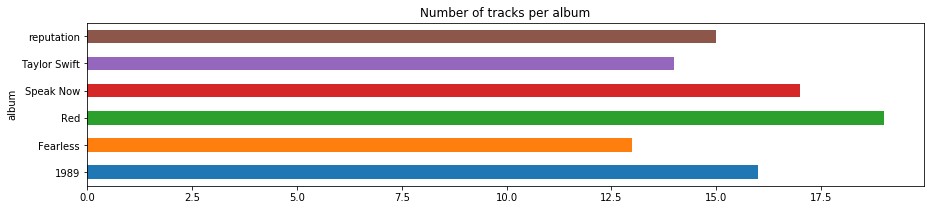

In [72]:
plt.figure(figsize=(15,3))
data.groupby('album').track_n.max().plot.barh()
plt.title('Number of tracks per album');

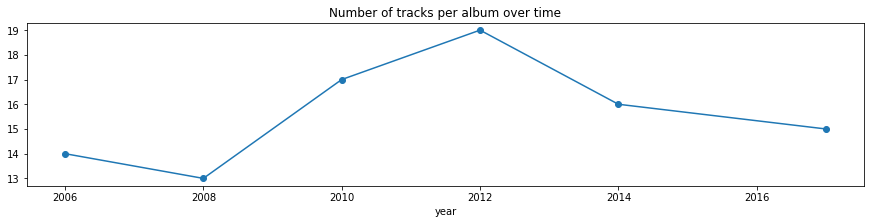

In [73]:
plt.figure(figsize=(15,3))
data.groupby('year').track_n.max().plot(marker='o')
plt.title('Number of tracks per album over time');

## Feature Engineering

In [74]:
data.track_title.unique()

array(['Tim McGraw', 'Picture To Burn', 'Teardrops On My Guitar',
       'A Place In This World', 'Cold as You', 'The Outside',
       'Tied Together With A Smile', 'Stay Beautiful',
       "Should've Said No", "Mary's Song (Oh My My My)", 'Our Song',
       "I'm Only Me When I'm With You", 'Invisible',
       'A Perfectly Good Heart', 'Fearless', 'Fifteen', 'Love Story',
       'Hey Stephen', 'White Horse', 'You Belong With Me',
       'Breathe (Ft. Colbie Caillat)', 'Tell Me Why', "You're Not Sorry",
       'The Way I Loved You', 'Forever & Always', 'The Best Day',
       'Change', 'Mine', 'Sparks Fly', 'Back To December', 'Speak Now',
       'Dear John', 'Mean', 'The Story of Us', 'Never Grow Up',
       'Enchanted', 'Better Than Revenge', 'Innocent', 'Haunted',
       'Last Kiss', 'Long Live', 'Ours', 'If This Was a Movie',
       'Superman', 'State of Grace', 'Red', 'Treacherous',
       'I Knew You Were Trouble', 'All Too Well', '22', 'I Almost Do',
       'We Are Never Ever Gett

In [75]:
def get_features(df):    
    df['lyric'] = df['lyric'].apply(lambda x:str(x))
    df['total_length'] = df['lyric'].apply(len)
    df['capitals'] = df['lyric'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['total_length']),
                                axis=1)
    df['num_words'] = df.lyric.str.count('\S+')
    df['num_unique_words'] = df['lyric'].apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words']  
    return df

In [76]:
train = get_features(data.copy())

In [77]:
train.head()

,artist,album,track_title,track_n,lyric,line,year,total_length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique
0,Taylor Swift,Taylor Swift,Tim McGraw,1,He said the way my blue eyes shined,1,2006,35,1,0.028571,8,8,1.000000
1,Taylor Swift,Taylor Swift,Tim McGraw,1,Put those Georgia stars to shame that night,2,2006,43,2,0.046512,8,8,1.000000
2,Taylor Swift,Taylor Swift,Tim McGraw,1,"I said, ""That's a lie""",3,2006,22,2,0.090909,5,5,1.000000
3,Taylor Swift,Taylor Swift,Tim McGraw,1,Just a boy in a Chevy truck,4,2006,27,2,0.074074,7,6,0.857143
4,Taylor Swift,Taylor Swift,Tim McGraw,1,That had a tendency of gettin' stuck,5,2006,36,1,0.027778,7,7,1.000000


## Model

## Visualize